# Metro Interstate Traffic Volume

URL : http://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

The dataset contains the detailed attributes for every player registered in the latest edition of FIFA 19 database.

Number of Instances: 48204

Attribute Characteristics: integer, real

Number of Attributes: 9

Missing Values: N/A

The target variable is the *traffic_volume*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from datetime import datetime

from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import seaborn as sns

%matplotlib inline

In [2]:
metro_data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", sep=',', index_col=False)

In [3]:
metro_data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,Christmas Day,264.40,0.00,0.0,90,Clouds,overcast clouds,25-12-12 0:00,803
1,Christmas Day,260.17,0.25,0.0,64,Rain,light rain,25-12-13 0:00,712
2,Christmas Day,269.09,0.00,0.0,90,Snow,light snow,25-12-15 0:00,894
3,Christmas Day,276.08,0.00,0.0,90,Rain,light rain,26-12-16 0:00,732
4,Christmas Day,276.08,0.00,0.0,90,Mist,mist,26-12-16 0:00,732


In [4]:
metro_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [5]:
metro_data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


By analyzing the statistics, we can observe that:
- temp is in Kelvin
- rain_1h and temp contain outliers
- snow_1h values are spread through the range [0.0, 0.5]

We have to check whether the outliers are valid or not later on.

In [6]:
print(metro_data.isna().sum())
print('Total number of null values: ', metro_data.isna().sum().sum())

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64
Total number of null values:  0


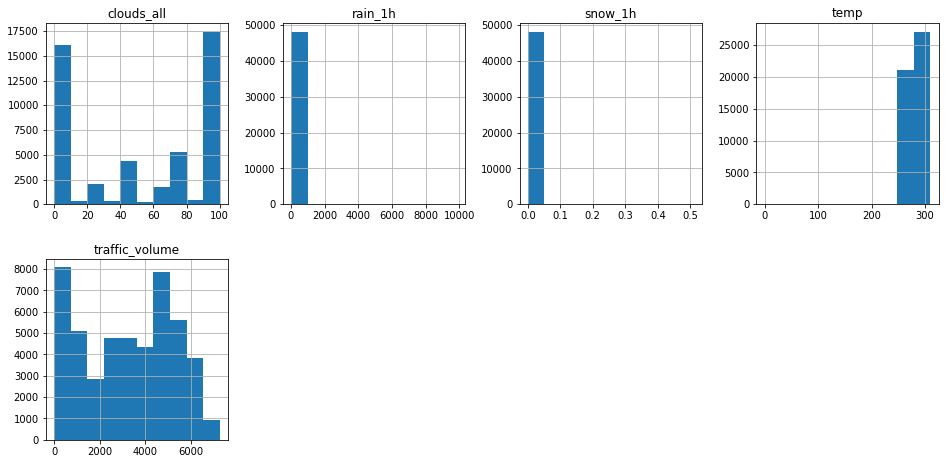

In [7]:
metro_data.hist(layout=(3,4), figsize=(16,12))
plt.show()

**We can see all the numerical categories and their values range in the histogram plot.**
- In clouds_all column more values are in the range 90-100 and 0-10.
- In rain_1h and snow_1h are having low decimal values and in range 0-5 and 0.0-0.05 respectively.
- In temp columns the minimum value is around 200 and maximum value is 310 and have good distribution in 250 -310.
- In traffic_volume column the data is well distributed throughout the range.

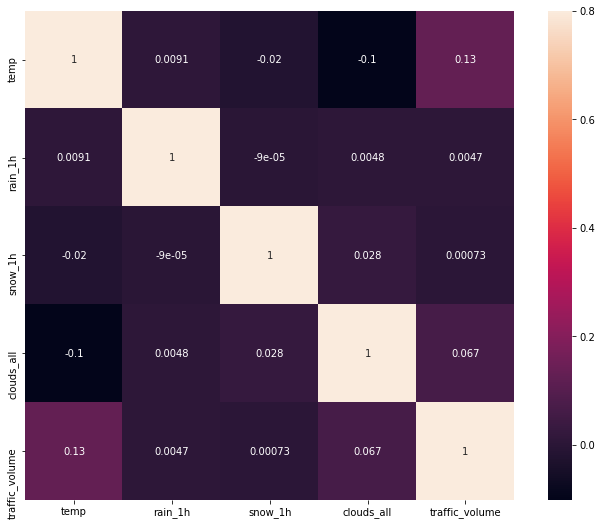

In [8]:
correlation_matrix = metro_data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix, vmax=0.8, square=True, annot=True)
plt.show()

- From correlation plot we can say that all the columns positively correlated with output variable traffic_volume. But they are not strongly correlated.

In [9]:
dups = metro_data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

print('Number of rows before discarding duplicates = %d' % (metro_data.shape[0]))
metro_data = metro_data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (metro_data.shape[0]))

Number of duplicate rows = 17
Number of rows before discarding duplicates = 48204
Number of rows after discarding duplicates = 48187


In [10]:
for col_name in metro_data.columns:
    if metro_data[col_name].dtypes == "object":
        unique_cat = len(metro_data[col_name].unique())
        print("Feature {col_name} has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature holiday has 12 unique categories
Feature weather_main has 11 unique categories
Feature weather_description has 38 unique categories
Feature date_time has 40575 unique categories


In [11]:
# Converting weather_main from object to category datatype
metro_data['weather_main'] = metro_data['weather_main'].astype('category')
metro_data['weather_description'] = metro_data['weather_description'].astype('category')

# Create new columns from the date_time attribute by separating it into four parts: date, month, weekday and hour.
metro_data['date_time'] = pd.to_datetime(metro_data['date_time'])
metro_data['date'] = pd.DatetimeIndex(metro_data['date_time']).strftime("%Y-%m-%d")
metro_data['month'] = metro_data['date_time'].dt.month.astype('category')
metro_data['weekday'] = metro_data['date_time'].dt.weekday.astype('category')
metro_data['hour'] = metro_data['date_time'].dt.hour.astype('category')

In [12]:
metro_data['holiday'].value_counts().sort_values(ascending=False)

None                         48126
Labor Day                        7
Christmas Day                    6
Martin Luther King Jr Day        6
New Years Day                    6
Thanksgiving Day                 6
Memorial Day                     5
Independence Day                 5
Columbus Day                     5
State Fair                       5
Washingtons Birthday             5
Veterans Day                     5
Name: holiday, dtype: int64

We can see that the holiday column has most of its value to "None" and also very small amount of holidays. 
Based on that, we check and correct any incorrect holiday entry for that specific day.

In [13]:
# Clean up the incorrect holiday entries
holiday_dict = dict()
n = len(metro_data)
for i in range(n):
    date_entry = metro_data.iloc[i]['date']
    holiday_entry = metro_data.iloc[i]['holiday']
    if (holiday_entry != "None"): holiday_dict[date_entry] = holiday_entry
for lookupDate in holiday_dict:
    metro_data.loc[metro_data['date']==lookupDate, 'holiday'] = holiday_dict[lookupDate]

In [14]:
metro_data['holiday'].value_counts().sort_values(ascending=False)

None                         46778
Labor Day                      157
Washingtons Birthday           136
Thanksgiving Day               135
Memorial Day                   134
Christmas Day                  131
New Years Day                  131
Independence Day               126
State Fair                     120
Veterans Day                   120
Columbus Day                   112
Martin Luther King Jr Day      107
Name: holiday, dtype: int64

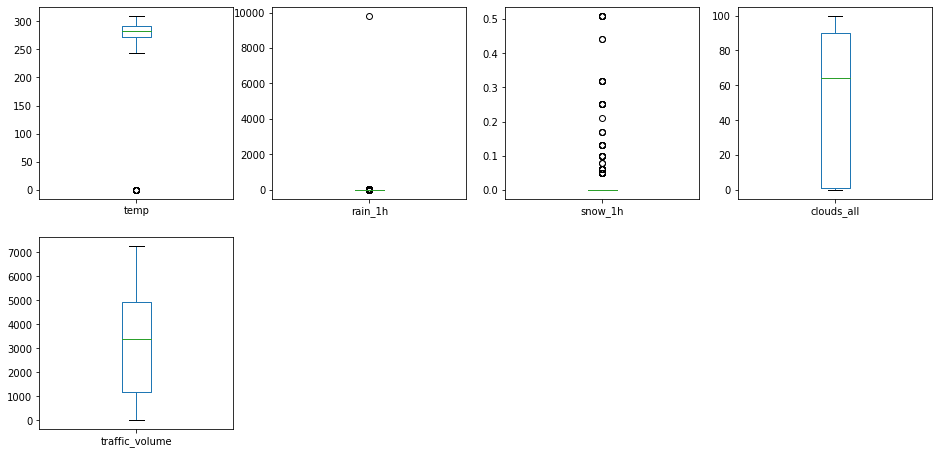

In [15]:
metro_data.plot(kind="box", subplots=True, layout=(3,4), figsize=(16,12))
plt.show()

From the Box Plot we can say there are outliers in the columns `rain_1h` and `temp`. Now we have to check whether its valid one or not. Wheares `snow_1h` values are spread throughout the range.

In [16]:
# rain_1h column
metro_data[(metro_data['rain_1h'] == metro_data['rain_1h'].max())]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date,month,weekday,hour
24881,None,302.11,9831.3,0.0,75,Rain,very heavy rain,2016-11-07 17:00:00,5535,2016-11-07,11,0,17


By extracting the whole row we can say the data is valid. since it comes under very heavy rain. but we need to compare it with the other records which has `very heavy rain`.

In [17]:
metro_data[(metro_data['weather_description']=='very heavy rain')].tail(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date,month,weekday,hour
14875,None,298.21,18.03,0.0,0,Rain,very heavy rain,2014-02-06 16:00:00,6443,2014-02-06,2,3,16
16321,None,294.87,23.80,0.0,90,Rain,very heavy rain,2015-06-07 03:00:00,346,2015-06-07,6,6,3
16525,None,292.02,27.57,0.0,90,Rain,very heavy rain,2015-07-13 00:00:00,492,2015-07-13,7,0,0
16944,None,295.12,20.24,0.0,90,Rain,very heavy rain,2015-07-28 07:00:00,4302,2015-07-28,7,1,7
17458,None,294.49,25.46,0.0,90,Rain,very heavy rain,2015-08-16 21:00:00,2118,2015-08-16,8,6,21
24881,None,302.11,9831.30,0.0,75,Rain,very heavy rain,2016-11-07 17:00:00,5535,2016-11-07,11,0,17
25490,None,294.92,16.51,0.0,32,Rain,very heavy rain,2016-04-08 07:00:00,5724,2016-04-08,4,4,7
25648,None,292.70,18.42,0.0,80,Rain,very heavy rain,2016-10-08 21:00:00,1904,2016-10-08,10,5,21
25788,None,297.71,31.75,0.0,0,Rain,very heavy rain,2016-08-16 17:00:00,4913,2016-08-16,8,1,17
25970,None,294.07,20.07,0.0,40,Rain,very heavy rain,2016-08-23 22:00:00,1520,2016-08-23,8,1,22


We can conclude that the data is an outlier or an type error when compared with the other relative data. data with clouds_all having higher value than this has less rain_1h. So it has to be handeled or dropped.

In [18]:
# temp column
metro_data[(metro_data['temp'] == metro_data['temp'].min())]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date,month,weekday,hour
11922,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:00,361,2014-01-31,1,4,3
11923,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:00,734,2014-01-31,1,4,4
11924,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:00,2557,2014-01-31,1,4,5
11925,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150,2014-01-31,1,4,6
11970,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:00,291,2014-02-02,2,6,3
11971,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:00,284,2014-02-02,2,6,4
11972,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:00,434,2014-02-02,2,6,5
11973,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739,2014-02-02,2,6,6
11974,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962,2014-02-02,2,6,7
11975,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670,2014-02-02,2,6,8


In temperature column the values are zero for particular occurance and the time is also continuous .So it might be due to the temperature would not have been noted and filled as zero. We need to fill it with relative values

### Handling Outliers

In [19]:
# Converting temperature from Kelvin to Celcius & correct some zero degree Kelvin entries by setting them to mean
mean_temp = metro_data['temp'].mean()
metro_data.loc[metro_data.temp == 0, 'temp'] = mean_temp
metro_data['temp'] = metro_data['temp'] - 273.15

In [20]:
metro_data["rain_1h"].sort_values(ascending=False)

24881    9831.30
8279       55.63
7212       44.45
25788      31.75
10834      28.70
          ...   
31796       0.00
31795       0.00
31794       0.00
31793       0.00
0           0.00
Name: rain_1h, Length: 48187, dtype: float64

In [21]:
# Setting rainfall max value of 9831.30 to 55.63
metro_data.loc[metro_data.rain_1h == 9831.30 , 'rain_1h'] = 55.63

### Drop unnecessary features

In [22]:
metro_data["weather_description"].sort_values(ascending=False)

25490    very heavy rain
17458    very heavy rain
7702     very heavy rain
7212     very heavy rain
25648    very heavy rain
              ...       
25626       Sky is Clear
8293             SQUALLS
25296            SQUALLS
7165             SQUALLS
5992             SQUALLS
Name: weather_description, Length: 48187, dtype: category
Categories (38, object): [SQUALLS, Sky is Clear, broken clouds, drizzle, ..., thunderstorm with light drizzle, thunderstorm with light rain, thunderstorm with rain, very heavy rain]

In [23]:
metro_data.corr()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
temp,1.000000,0.089041,-0.020861,-0.112835,0.132129
rain_1h,0.089041,1.000000,0.001447,0.079771,-0.020390
snow_1h,-0.020861,0.001447,1.000000,0.027934,0.000736
clouds_all,-0.112835,0.079771,0.027934,1.000000,0.067138
traffic_volume,0.132129,-0.020390,0.000736,0.067138,1.000000


In [24]:
# Drop the un-needed features
metro_data.drop(columns=['date_time', 'date', 'weather_description'], inplace=True)

In [25]:
metro_data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,weekday,hour
0,Christmas Day,-8.75,0.00,0.0,90,Clouds,803,12,1,0
1,Christmas Day,-12.98,0.25,0.0,64,Rain,712,12,2,0
2,Christmas Day,-4.06,0.00,0.0,90,Snow,894,12,4,0
3,Christmas Day,2.93,0.00,0.0,90,Rain,732,12,0,0
4,Christmas Day,2.93,0.00,0.0,90,Mist,732,12,0,0


In [26]:
metro_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48187 entries, 0 to 48203
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   holiday         48187 non-null  object  
 1   temp            48187 non-null  float64 
 2   rain_1h         48187 non-null  float64 
 3   snow_1h         48187 non-null  float64 
 4   clouds_all      48187 non-null  int64   
 5   weather_main    48187 non-null  category
 6   traffic_volume  48187 non-null  int64   
 7   month           48187 non-null  category
 8   weekday         48187 non-null  category
 9   hour            48187 non-null  category
dtypes: category(4), float64(3), int64(2), object(1)
memory usage: 2.8+ MB


In [27]:
metro_data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000
mean,8.113352,0.131512,0.000222,49.365451,3259.618134
std,12.708576,1.034900,0.008169,39.015213,1986.954465
min,-29.760000,0.000000,0.000000,0.000000,0.000000
25%,-0.960000,0.000000,0.000000,1.000000,1192.500000
50%,9.300000,0.000000,0.000000,64.000000,3379.000000
75%,18.656000,0.000000,0.000000,90.000000,4933.000000
max,36.920000,55.630000,0.510000,100.000000,7280.000000


We will split the data into X and y where X contains the attributes and y is the target variable

In [28]:
X = metro_data.drop(['traffic_volume'], axis=1)
y = metro_data['traffic_volume']

print("metro_data.shape: {} X.shape: {} y.shape: {}".format(metro_data.shape, X.shape, y.shape))

metro_data.shape: (48187, 10) X.shape: (48187, 9) y.shape: (48187,)


In [29]:
X.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,month,weekday,hour
0,Christmas Day,-8.750,0.00,0.0,90,Clouds,12,1,0
1,Christmas Day,-12.980,0.25,0.0,64,Rain,12,2,0
2,Christmas Day,-4.060,0.00,0.0,90,Snow,12,4,0
3,Christmas Day,2.930,0.00,0.0,90,Rain,12,0,0
4,Christmas Day,2.930,0.00,0.0,90,Mist,12,0,0
5,Christmas Day,-15.200,0.00,0.0,1,Clear,12,0,0
6,Columbus Day,-0.070,0.00,0.0,20,Clouds,8,4,0
7,Columbus Day,4.570,0.00,0.0,0,Clear,10,0,0
8,Columbus Day,19.870,0.00,0.0,1,Clear,12,3,0
9,Columbus Day,9.191,0.00,0.0,0,Clear,10,0,0


In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48187 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   holiday       48187 non-null  object  
 1   temp          48187 non-null  float64 
 2   rain_1h       48187 non-null  float64 
 3   snow_1h       48187 non-null  float64 
 4   clouds_all    48187 non-null  int64   
 5   weather_main  48187 non-null  category
 6   month         48187 non-null  category
 7   weekday       48187 non-null  category
 8   hour          48187 non-null  category
dtypes: category(4), float64(3), int64(1), object(1)
memory usage: 2.4+ MB


In [31]:
X.describe()

,temp,rain_1h,snow_1h,clouds_all
count,48187.000000,48187.000000,48187.000000,48187.000000
mean,8.113352,0.131512,0.000222,49.365451
std,12.708576,1.034900,0.008169,39.015213
min,-29.760000,0.000000,0.000000,0.000000
25%,-0.960000,0.000000,0.000000,1.000000
50%,9.300000,0.000000,0.000000,64.000000
75%,18.656000,0.000000,0.000000,90.000000
max,36.920000,55.630000,0.510000,100.000000


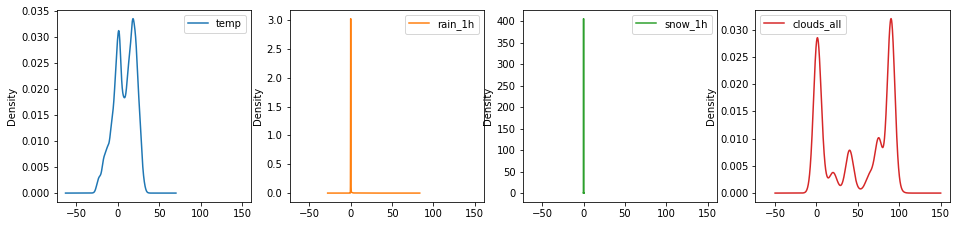

In [32]:
X.plot(kind='density', subplots=True, layout=(3,4), figsize=(16,12))
plt.show()

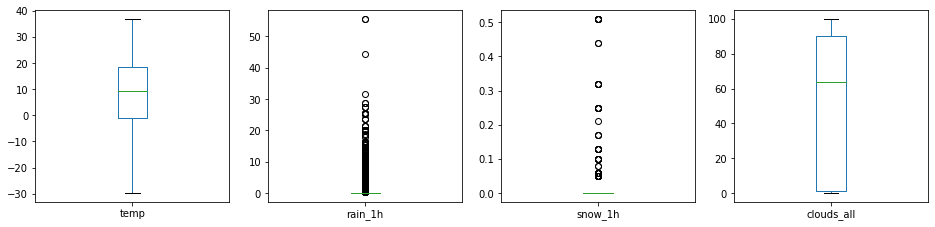

In [33]:
X.plot(kind='box', subplots=True, layout=(3,4), figsize=(16,12))
plt.show()

In [34]:
X['holiday'].value_counts().sort_values(ascending=False)

None                         46778
Labor Day                      157
Washingtons Birthday           136
Thanksgiving Day               135
Memorial Day                   134
Christmas Day                  131
New Years Day                  131
Independence Day               126
State Fair                     120
Veterans Day                   120
Columbus Day                   112
Martin Luther King Jr Day      107
Name: holiday, dtype: int64

While most of the values in the holiday variable are *None* then we can replace **None** => **No**, and all the other values => **Yes**.

The same we will do with `rain_1h`, `snow_1h` and `clouds_all`. We will binarize these columns by setting the threshold=0.0 for `rain_1` and `snow_1h` because most of the values are 0.0 and for `clouds_all` we will set the threshold 50 because of the mean value.

In [35]:
X['holiday'] = ["No" if x == 'None' else 'Yes' for x in X['holiday']]

In [36]:
X['holiday'].value_counts().sort_values(ascending=False)

No     46778
Yes     1409
Name: holiday, dtype: int64

In [37]:
X['rain_1h'].value_counts().sort_values(ascending=False)

0.00    44720
0.25      948
0.51      256
1.02      123
0.30      121
        ...  
5.41        1
7.13        1
2.11        1
3.91        1
1.90        1
Name: rain_1h, Length: 371, dtype: int64

In [38]:
discrete_rain = preprocessing.Binarizer(threshold=0.0)
rain_binned = discrete_rain.fit_transform(X[['rain_1h']])
X['rain_binarized'] = rain_binned

In [39]:
X['snow_1h'].value_counts().sort_values(ascending=False)

0.00    48124
0.05       14
0.06       12
0.25        6
0.51        6
0.13        6
0.10        6
0.32        5
0.17        3
0.44        2
0.08        2
0.21        1
Name: snow_1h, dtype: int64

In [40]:
discrete_snow = preprocessing.Binarizer(threshold=0.0)
snow_binned = discrete_rain.fit_transform(X[['snow_1h']])
X['snow_binarized'] = snow_binned

In [41]:
X['clouds_all'].value_counts().sort_values(ascending=False)

90     16437
1      12754
75      5068
40      3992
0       1987
20      1849
64      1558
5       1094
92       776
12       273
8        270
24       186
32       185
88       183
80       181
48       180
68       179
36       169
56       164
76       153
44       147
100       94
99        44
93        34
98        21
87        18
85        17
59        16
96        14
57        13
89        13
91        12
81        11
46         9
97         8
77         7
6          6
11         5
83         5
16         5
63         5
25         4
70         4
58         4
4          3
13         3
72         3
3          3
50         2
42         2
38         2
2          2
54         2
86         2
62         2
60         2
67         2
17         1
84         1
78         1
Name: clouds_all, dtype: int64

In [42]:
discrete_clouds = preprocessing.Binarizer(threshold=50.0)
clouds_binned = discrete_rain.fit_transform(X[['clouds_all']])
X['clouds_binarized'] = clouds_binned

Because we created new columns for `rain_1h`, `snow_1h` and `clouds_all`, we can drop the old columns.

In [43]:
X.drop(columns=['rain_1h', 'snow_1h', 'clouds_all'], inplace=True)

In [44]:
X.head(10)

,holiday,temp,weather_main,month,weekday,hour,rain_binarized,snow_binarized,clouds_binarized
0,Yes,-8.750,Clouds,12,1,0,0.0,0.0,1
1,Yes,-12.980,Rain,12,2,0,1.0,0.0,1
2,Yes,-4.060,Snow,12,4,0,0.0,0.0,1
3,Yes,2.930,Rain,12,0,0,0.0,0.0,1
4,Yes,2.930,Mist,12,0,0,0.0,0.0,1
5,Yes,-15.200,Clear,12,0,0,0.0,0.0,1
6,Yes,-0.070,Clouds,8,4,0,0.0,0.0,1
7,Yes,4.570,Clear,10,0,0,0.0,0.0,0
8,Yes,19.870,Clear,12,3,0,0.0,0.0,1
9,Yes,9.191,Clear,10,0,0,0.0,0.0,0


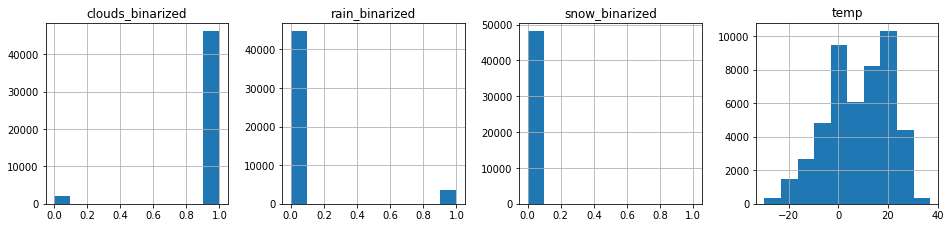

In [45]:
X.hist(layout=(3,4), figsize=(16,12))
plt.show()

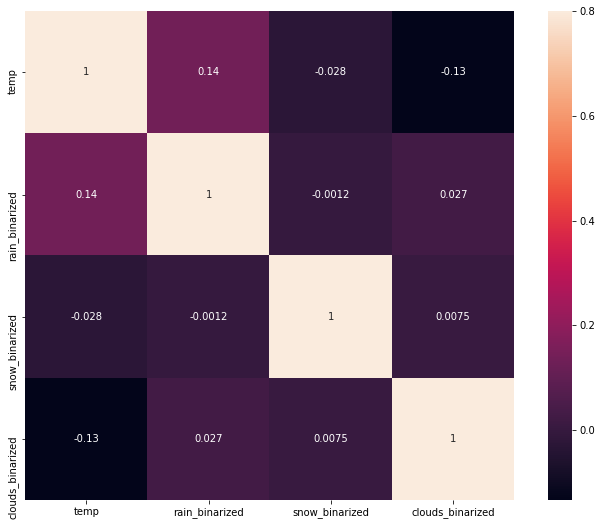

In [46]:
correlation_matrix = X.corr()
plt.figure(figsize=(12,9))
sns.heatmap(correlation_matrix, vmax=0.8, square=True, annot=True)
plt.show()

From the correlation matrix we can see that none of the variables are correlated with each other

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48187 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   holiday           48187 non-null  object  
 1   temp              48187 non-null  float64 
 2   weather_main      48187 non-null  category
 3   month             48187 non-null  category
 4   weekday           48187 non-null  category
 5   hour              48187 non-null  category
 6   rain_binarized    48187 non-null  float64 
 7   snow_binarized    48187 non-null  float64 
 8   clouds_binarized  48187 non-null  int64   
dtypes: category(4), float64(3), int64(1), object(1)
memory usage: 2.4+ MB


We will use pandas `get_dummies` function to convert categorical features to numeric and also we will use `PCA` to select **30** components from the *X_with_dummies*.

In [48]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

X_with_dummies = pd.get_dummies(X)
X_with_dummies = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X_with_dummies), columns=X_with_dummies.columns)

pca = PCA(n_components=30)
principalComponents = pca.fit_transform(X_with_dummies)

X_PCA_with_dummies = pd.DataFrame(principalComponents)
print("PCA Variance = ", sum(pca.explained_variance_).round(2))
print("PCA Variance Ratio = ", sum(pca.explained_variance_ratio_).round(2))
print("X_with_dummies shape", X_with_dummies.shape)
print("X_PCA_with_dummies shape", X_PCA_with_dummies.shape)

PCA Variance =  2.89
PCA Variance Ratio =  0.78
X_with_dummies shape (48187, 60)
X_PCA_with_dummies shape (48187, 30)


### Modeling

For testing regression techniques, we will use three train/test splits of data.
- The first split will contain the all the numeric features (4 in total)
- The second split will contain all the numeric features and also the categorical features that we converted into numeric using pandas get_dummies function (60 in total).
- The third split will use `PCA` in `X_with_dummies` to select 30 components.

In [49]:
randNum = 1234

In [50]:
# Use 75% of the data to train the models and the remaining for testing/validation
X_numeric = X.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.25, random_state=randNum)
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train_with_dummies, X_test_with_dummies, y_train_with_dummies, y_test_with_dummies = train_test_split(X_with_dummies, y, test_size=0.25, random_state=randNum)
print("X_train_with_dummies.shape: {} y_train_with_dummies.shape: {}".format(X_train_with_dummies.shape, y_train_with_dummies.shape))
print("X_test_with_dummies.shape: {} y_test_with_dummies.shape: {}".format(X_test_with_dummies.shape, y_test_with_dummies.shape))

X_train_PCA_with_dummies, X_test_PCA_with_dummies, y_train_PCA_with_dummies, y_test_PCA_with_dummies = train_test_split(X_PCA_with_dummies, y, test_size=0.25, random_state=randNum)
print("X_train_PCA_with_dummies.shape: {} y_train_PCA_with_dummies.shape: {}".format(X_train_PCA_with_dummies.shape, y_train_PCA_with_dummies.shape))
print("X_test_PCA_with_dummies.shape: {} y_test_PCA_with_dummies.shape: {}".format(X_test_PCA_with_dummies.shape, y_test_PCA_with_dummies.shape))

X_train.shape: (36140, 4) y_train.shape: (36140,)
X_test.shape: (12047, 4) y_test.shape: (12047,)
X_train_with_dummies.shape: (36140, 60) y_train_with_dummies.shape: (36140,)
X_test_with_dummies.shape: (12047, 60) y_test_with_dummies.shape: (12047,)
X_train_PCA_with_dummies.shape: (36140, 30) y_train_PCA_with_dummies.shape: (36140,)
X_test_PCA_with_dummies.shape: (12047, 30) y_test_PCA_with_dummies.shape: (12047,)


In [51]:
parameters = [("All numeric columns", X_train, y_train, X_test, y_test),
              ("Dummy columns", X_train_with_dummies, y_train_with_dummies, X_test_with_dummies, y_test_with_dummies),
              ("Dummies and PCA", X_train_PCA_with_dummies, y_train_PCA_with_dummies, X_test_PCA_with_dummies, y_test_PCA_with_dummies)]


                              All numeric columns
Coefficient of determination         1.671378e-02
Mean Squared Error                   3.851478e+06
Root Mean Squared Error              1.962518e+03
Residual sum of squares              3.851478e+06


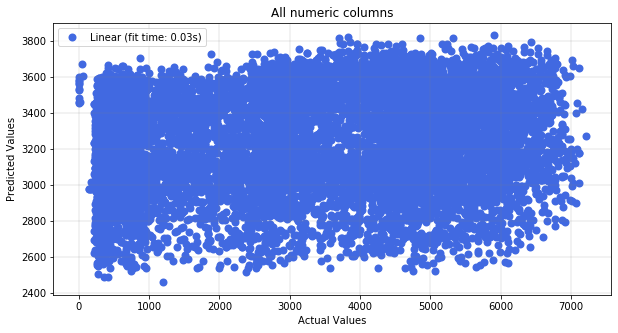


                              All numeric columns  Dummy columns
Coefficient of determination         1.671378e-02       0.813461
Mean Squared Error                   3.851478e+06  730661.229767
Root Mean Squared Error              1.962518e+03     854.787242
Residual sum of squares              3.851478e+06  730661.229767


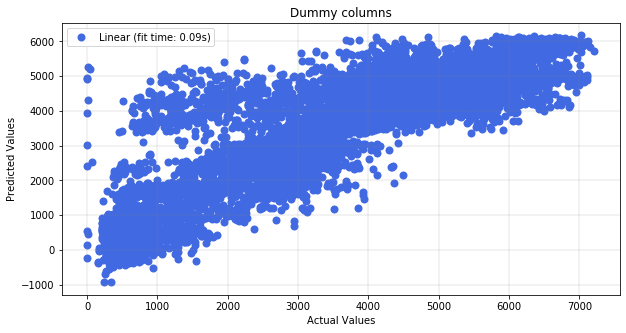


                              All numeric columns  Dummy columns  \
Coefficient of determination         1.671378e-02       0.813461   
Mean Squared Error                   3.851478e+06  730661.229767   
Root Mean Squared Error              1.962518e+03     854.787242   
Residual sum of squares              3.851478e+06  730661.229767   

                              Dummies and PCA  
Coefficient of determination     2.829807e-01  
Mean Squared Error               2.808525e+06  
Root Mean Squared Error          1.675865e+03  
Residual sum of squares          2.808525e+06  


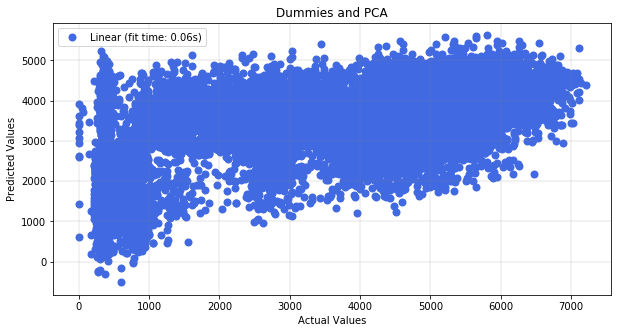

In [52]:
lw = 2
results = pd.DataFrame([], ['Coefficient of determination', 'Mean Squared Error', 'Root Mean Squared Error', 'Residual sum of squares'])
for titlePlot, X_train, y_train, X_test, y_test in parameters:
    plt.figure(figsize=(10,5))
    t0 = time.time()
    estimator = LinearRegression()
    estimator.fit(X_train, y_train)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(X_test)
    results[titlePlot] = [r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), np.mean((y_pred-y_test)**2)]
    plt.scatter(y_test, y_pred, color='royalblue', linewidth=lw, label='%s (fit time: %.2fs)' % ('Linear', elapsed_time))
    print("=================================================================================\n")
    print(results)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.legend(loc='upper left')
    plt.title(titlePlot)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

From the tables and plots we can see that the Linear Regression model performed best in the second split with dummy columns with `coef. of determination 0.813`.


                                Huber 1.35     Huber 1.5    Huber 1.75  \
Coefficient of determination  1.567969e-02  1.623659e-02  1.662666e-02   
Mean Squared Error            3.855528e+06  3.853347e+06  3.851819e+06   
Root Mean Squared Error       1.963550e+03  1.962994e+03  1.962605e+03   
Residual sum of squares       3.855528e+06  3.853347e+06  3.851819e+06   

                                 Huber 1.9  
Coefficient of determination  1.669233e-02  
Mean Squared Error            3.851562e+06  
Root Mean Squared Error       1.962540e+03  
Residual sum of squares       3.851562e+06  


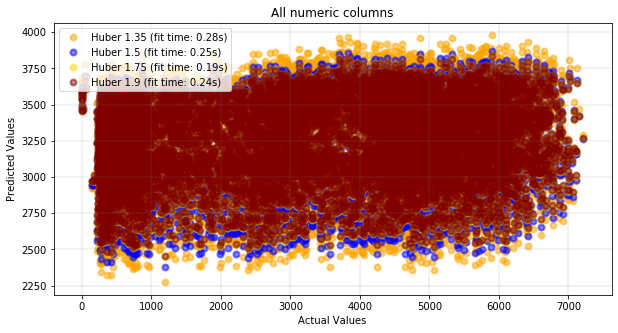


                                 Huber 1.35      Huber 1.5     Huber 1.75  \
Coefficient of determination       0.778117       0.785163       0.795258   
Mean Squared Error            869103.352313  841503.704051  801964.683474   
Root Mean Squared Error          932.257128     917.335110     895.524809   
Residual sum of squares       869103.352313  841503.704051  801964.683474   

                                  Huber 1.9  
Coefficient of determination       0.799758  
Mean Squared Error            784338.351508  
Root Mean Squared Error          885.628789  
Residual sum of squares       784338.351508  


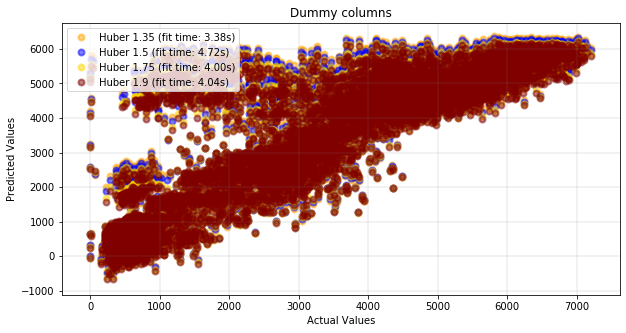


                                Huber 1.35     Huber 1.5    Huber 1.75  \
Coefficient of determination  2.682632e-01  2.761070e-01  2.811734e-01   
Mean Squared Error            2.866173e+06  2.835449e+06  2.815604e+06   
Root Mean Squared Error       1.692978e+03  1.683879e+03  1.677976e+03   
Residual sum of squares       2.866173e+06  2.835449e+06  2.815604e+06   

                                 Huber 1.9  
Coefficient of determination  2.823894e-01  
Mean Squared Error            2.810841e+06  
Root Mean Squared Error       1.676556e+03  
Residual sum of squares       2.810841e+06  


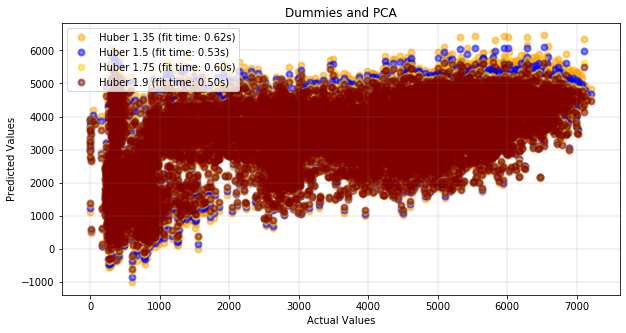

In [53]:
estimators = [('Huber 1.35', HuberRegressor(epsilon=1.35)),
              ('Huber 1.5', HuberRegressor(epsilon=1.5)),
              ('Huber 1.75', HuberRegressor(epsilon=1.75)),
              ('Huber 1.9', HuberRegressor(epsilon=1.9))]
colors = {'Huber 1.35': 'orange', 'Huber 1.5': 'blue', 'Huber 1.75': 'gold', 'Huber 1.9': 'maroon'}
lw = 2
results = pd.DataFrame([], ['Coefficient of determination', 'Mean Squared Error', 'Root Mean Squared Error', 'Residual sum of squares'])
for titlePlot, X_train, y_train, X_test, y_test in parameters:
    plt.figure(figsize=(10,5))
    for name, estimator in estimators:
        t0 = time.time()
        estimator.fit(X_train, y_train)
        elapsed_time = time.time() - t0
        y_pred = estimator.predict(X_test)
        results[name] = [r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), np.mean((y_pred-y_test)**2)]
        plt.scatter(y_test, y_pred, color=colors[name], linewidth=lw, alpha=0.5, label='%s (fit time: %.2fs)' % (name, elapsed_time))
    print("=================================================================================\n")
    print(results)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.legend(loc='upper left')
    plt.title(titlePlot)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

Huber Regressor model performed best in the second split with dummy columns and with `coef. of determination ~0.8`.

==============================RandomForestRegressor==============================


                                     50-10         50-05        150-10  \
Coefficient of determination  4.457337e-02  3.762355e-02  4.467917e-02   
Mean Squared Error            3.742353e+06  3.769575e+06  3.741939e+06   
Root Mean Squared Error       1.934516e+03  1.941539e+03  1.934409e+03   
Residual sum of squares       3.742353e+06  3.769575e+06  3.741939e+06   

                                    150-05        300-10        300-05  
Coefficient of determination  3.746771e-02  4.481209e-02  3.742095e-02  
Mean Squared Error            3.770186e+06  3.741418e+06  3.770369e+06  
Root Mean Squared Error       1.941697e+03  1.934275e+03  1.941744e+03  
Residual sum of squares       3.770186e+06  3.741418e+06  3.770369e+06  


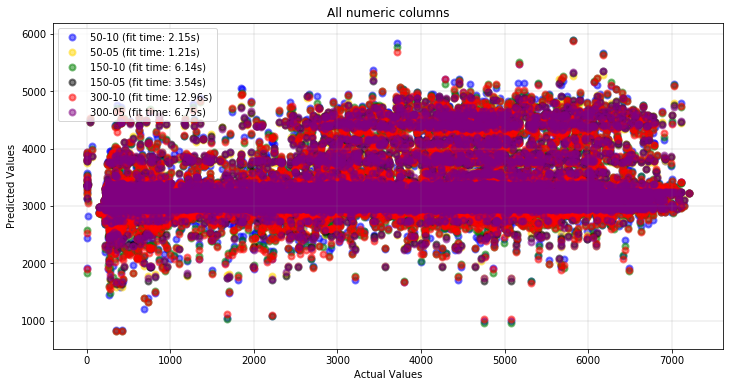


                                     50-10         50-05        150-10  \
Coefficient of determination  7.413656e-01  5.080439e-01  7.413333e-01   
Mean Squared Error            1.013057e+06  1.926965e+06  1.013183e+06   
Root Mean Squared Error       1.006507e+03  1.388152e+03  1.006570e+03   
Residual sum of squares       1.013057e+06  1.926965e+06  1.013183e+06   

                                    150-05        300-10        300-05  
Coefficient of determination  5.080191e-01  7.413197e-01  5.080140e-01  
Mean Squared Error            1.927062e+06  1.013237e+06  1.927082e+06  
Root Mean Squared Error       1.388187e+03  1.006597e+03  1.388194e+03  
Residual sum of squares       1.927062e+06  1.013237e+06  1.927082e+06  


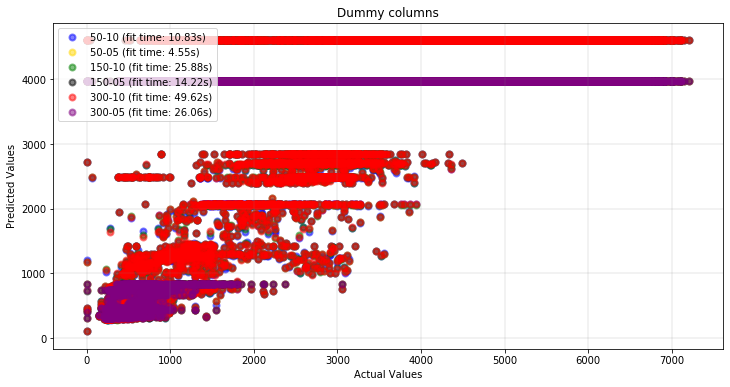


                                      50-10         50-05         150-10  \
Coefficient of determination       0.822744  6.856119e-01       0.823092   
Mean Squared Error            694301.069454  1.231441e+06  692937.748069   
Root Mean Squared Error          833.247304  1.109703e+03     832.428825   
Residual sum of squares       694301.069454  1.231441e+06  692937.748069   

                                    150-05         300-10        300-05  
Coefficient of determination  6.856560e-01       0.823157  6.853789e-01  
Mean Squared Error            1.231268e+06  692683.131587  1.232353e+06  
Root Mean Squared Error       1.109625e+03     832.275875  1.110114e+03  
Residual sum of squares       1.231268e+06  692683.131587  1.232353e+06  


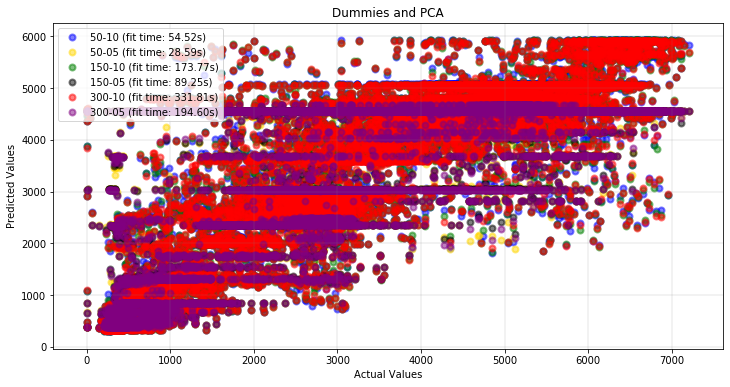

In [54]:
print("==============================RandomForestRegressor==============================\n")
estimators = [("50-10", RandomForestRegressor(n_estimators=50, max_depth=10, random_state=randNum)),
              ("50-05", RandomForestRegressor(n_estimators=50, max_depth=5, random_state=randNum)),
              ("150-10", RandomForestRegressor(n_estimators=150, max_depth=10, random_state=randNum)),
              ("150-05", RandomForestRegressor(n_estimators=150, max_depth=5, random_state=randNum)),
              ("300-10", RandomForestRegressor(n_estimators=300, max_depth=10, random_state=randNum)),
              ("300-05", RandomForestRegressor(n_estimators=300, max_depth=5, random_state=randNum))]
results = pd.DataFrame([], ['Coefficient of determination', 'Mean Squared Error', 'Root Mean Squared Error', 'Residual sum of squares'])
colors = {'50-10': 'blue', '50-05': 'gold', '150-10': 'green', '150-05': 'black', '300-10': 'red', '300-05': 'purple'}
lw = 2
for titlePlot, X_train, y_train, X_test, y_test in parameters:
    plt.figure(figsize=(12, 6))
    for name, estimator in estimators:
        t0 = time.time()
        estimator.fit(X_train, y_train)
        elapsed_time = time.time() - t0
        y_pred = estimator.predict(X_test)
        results[name] = [r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), np.mean((y_pred-y_test)**2)]
        plt.scatter(y_test, y_pred, color=colors[name], linewidth=lw, alpha=0.5, label='%s (fit time: %.2fs)' % (name, elapsed_time))
    print("=================================================================================\n")
    print(results)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.legend(loc='upper left')
    plt.title(titlePlot)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

- In the first table we have the results of the first split. The best performer in terms of accuracy is the regressor with `n_estimator=300` and `max_depth=10`.
- In the second table we have the results of the second split. The best performer in terms of accuracy is the regressor with `n_estimator=300` and `max_depth=10`.
- In the third table we have the results of the third split. The best performer in terms of accuracy is the regressor with `n_estimator=300` and `max_depth=10`.

Overall the best performer is the third split with `n_estimator=300` and `max_depth=10`.


                                       Rbf       Rbf 1e3          Poly
Coefficient of determination  2.486839e-02  3.450947e-02  2.628872e-02
Mean Squared Error            3.819537e+06  3.781773e+06  3.813973e+06
Root Mean Squared Error       1.954364e+03  1.944678e+03  1.952940e+03
Residual sum of squares       3.819537e+06  3.781773e+06  3.813973e+06


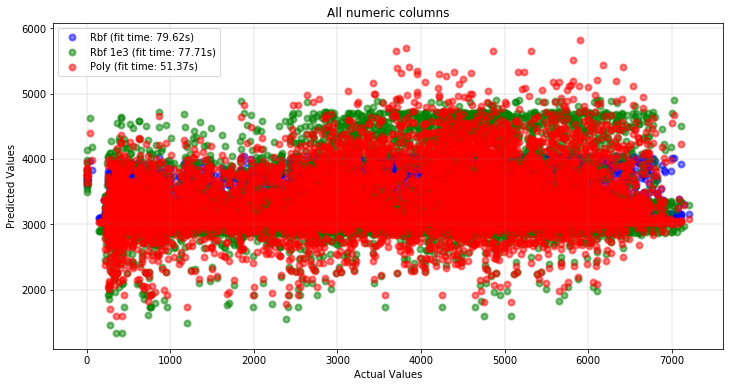


                                       Rbf        Rbf 1e3          Poly
Coefficient of determination  1.371383e-01       0.851214  1.942735e-01
Mean Squared Error            3.379782e+06  582786.920925  3.155986e+06
Root Mean Squared Error       1.838418e+03     763.404821  1.776510e+03
Residual sum of squares       3.379782e+06  582786.920925  3.155986e+06


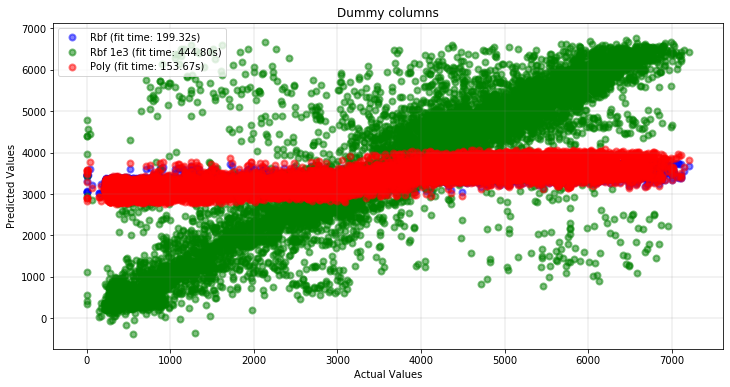


                                       Rbf        Rbf 1e3          Poly
Coefficient of determination  5.523228e-02       0.762736  2.863175e-02
Mean Squared Error            3.700603e+06  929350.709192  3.804796e+06
Root Mean Squared Error       1.923695e+03     964.028376  1.950589e+03
Residual sum of squares       3.700603e+06  929350.709192  3.804796e+06


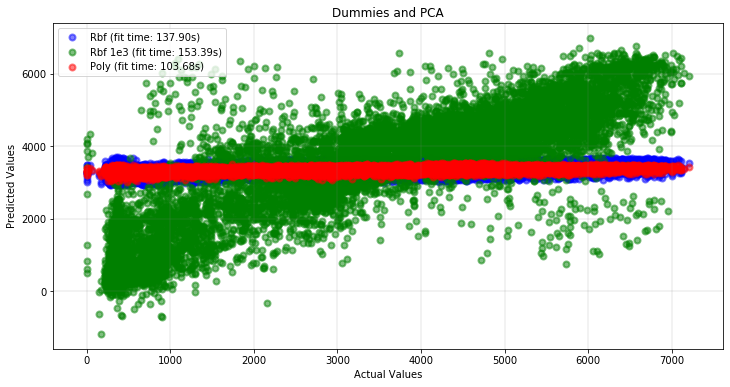

In [55]:
svr_regressors = [("Rbf", SVR(kernel='rbf', cache_size=500)),
                  ("Rbf 1e3", SVR(kernel='rbf', C=1e3, cache_size=500)),
                  ("Poly", SVR(kernel='poly'))]
colors = {"Rbf": "blue", "Rbf 1e3": "green", "Poly": "red"}
lw = 2
results = pd.DataFrame([], ['Coefficient of determination', 'Mean Squared Error', 'Root Mean Squared Error', 'Residual sum of squares'])
for titlePlot, X_train, y_train, X_test, y_test in parameters:
    plt.figure(figsize=(12, 6))
    for name, estimator in svr_regressors:
        t0 = time.time()
        estimator.fit(X_train, y_train)
        elapsed_time = time.time() - t0
        y_pred = estimator.predict(X_test)
        results[name] = [r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)), np.mean((y_pred-y_test)**2)]
        plt.scatter(y_test, y_pred, color=colors[name], linewidth=lw, alpha=0.5, label='%s (fit time: %.2fs)' % (name, elapsed_time))
    print("=================================================================================\n")
    print(results)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
    plt.legend(loc='upper left')
    plt.title(titlePlot)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.show()

- In the first table we have the results of the first split. The best performer in terms of accuracy is the regressor with `kernel='rbf'`, `C=1e3` and `cache_size=500`.
- In the second table we have the results of the second split. The best performer in terms of accuracy is the regressor with `kernel='rbf'`, `C=1e3` and `cache_size=500`.
- In the third table we have the results of the third split. The best performer in terms of accuracy is the regressor with `kernel='rbf'`, `C=1e3` and `cache_size=500`.

We see that in every split, parameters `kernel='rbf'`, `C=1e3` and `cache_size=500` performed best but in overall the best performer is the second split.